<a href="https://colab.research.google.com/github/aksalas/Car-Sales/blob/main/Car_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
# Imports

# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatPlotLib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns


# Regression Metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report
# Set the default transformation output to Pandas
from sklearn import set_config
set_config(transform_output='pandas')

from IPython.core.display import clear_output

# Functions

In [2]:
def eval_regression(true, pred, name='Model'):

    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name='Model'):

    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred))
    ConfusionMatrixDisplay.from_predictions(true, pred)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

In [3]:

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False, model_name =''):

  """This custom function accepts the model, X_train, y_train, X_test, and y_test
  Obtains the predictions from the model for both training and test data
  Inputs the true and predicted values into the helper function to obtain all the metrics for both the training and test data.
  Prints the results (optional with default as True
  Save the results as a dataframe (optional with default as False)"""

  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label= model_name + ' ' + 'Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label=model_name + ' ' + 'Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)



In [4]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                         output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                         label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                        output_dict=True,figsize=figsize,
                                        colorbar=colorbar, cmap=cmap_test,
                                        label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Car sales data

In [5]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQfLicudcbONFoaem30aKFT18It9CkP16yt9BcU2ogNwp1dlAS1GKFYgltolRw7jWQdMkE4wtsmqa26/pub?output=csv')

In [6]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4,Automatic,Front,04-May,Left wheel,Silver,4


In [7]:
df.shape

(19237, 18)

1. https://www.kaggle.com/datasets/sidharth178/car-prices-dataset?select=train.csv
2. Prices for each car sold
3. target = Price
4. a row represents a car
5. Categorical
6. 18 features
7. 19237 rows
8. I dont see any forseeable challenges with this dataset as of yet.

# Functions

In [8]:
# Set MatPlotLib default parameters

plt.rcParams.update({'figure.facecolor': 'white',
                          'font.weight': 'bold',
                      'patch.linewidth': 1.25,
                       'axes.facecolor': 'white',
                       'axes.edgecolor': 'black',
                       'axes.linewidth': 2,
                       'axes.titlesize': 14,
                     'axes.titleweight': 'bold',
                       'axes.labelsize': 12,
                     'axes.labelweight': 'bold',
                      'xtick.labelsize': 10,
                      'ytick.labelsize': 10,
                            'axes.grid': True,
                       'axes.grid.axis': 'y',
                           'grid.color': 'black',
                       'grid.linewidth': .5,
                           'grid.alpha': .25,
                   'scatter.edgecolors': 'black'})

# EDA

## Car Price

In [9]:
# rows and columns
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 19237 rows, and 18 columns.
The rows represent 19237 observations, and the columns represent 17 features and 1 target variable.


In [10]:
# looking at dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                19237 non-null  int64 
 1   Price             19237 non-null  int64 
 2   Levy              19237 non-null  object
 3   Manufacturer      19237 non-null  object
 4   Model             19237 non-null  object
 5   Prod. year        19237 non-null  int64 
 6   Category          19237 non-null  object
 7   Leather interior  19237 non-null  object
 8   Fuel type         19237 non-null  object
 9   Engine volume     19237 non-null  object
 10  Mileage           19237 non-null  object
 11  Cylinders         19237 non-null  int64 
 12  Gear box type     19237 non-null  object
 13  Drive wheels      19237 non-null  object
 14  Doors             19237 non-null  object
 15  Wheel             19237 non-null  object
 16  Color             19237 non-null  object
 17  Airbags     

In [11]:
# categorical data
df.describe(include='object')

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels,Doors,Wheel,Color
count,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237
unique,559,65,1590,11,2,7,107,7687,4,3,3,2,16
top,-,HYUNDAI,Prius,Sedan,Yes,Petrol,2,0 km,Automatic,Front,04-May,Left wheel,Black
freq,5819,3769,1083,8736,13954,10150,3916,721,13514,12874,18332,17753,5033


In [12]:
# numeric data
df.describe(include='number')

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [13]:
df['Mileage'] = df['Mileage'].str.replace(' km', '')
df['Mileage'] = df['Mileage'].astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                19237 non-null  int64 
 1   Price             19237 non-null  int64 
 2   Levy              19237 non-null  object
 3   Manufacturer      19237 non-null  object
 4   Model             19237 non-null  object
 5   Prod. year        19237 non-null  int64 
 6   Category          19237 non-null  object
 7   Leather interior  19237 non-null  object
 8   Fuel type         19237 non-null  object
 9   Engine volume     19237 non-null  object
 10  Mileage           19237 non-null  int64 
 11  Cylinders         19237 non-null  int64 
 12  Gear box type     19237 non-null  object
 13  Drive wheels      19237 non-null  object
 14  Doors             19237 non-null  object
 15  Wheel             19237 non-null  object
 16  Color             19237 non-null  object
 17  Airbags     

## Duplicates

In [15]:
# checking to see any duplicated rows
df.duplicated().sum()

313

In [16]:
# dropping the duplicated rows rows
df = df.drop_duplicates()

In [17]:
# Checking again to see if they were properly dropped
df.duplicated().sum()

0

## Missing Values

In [18]:
df.isna().sum().sum()
# No need to deal with missing values

0

## Dropping Unnecessary columns
- the ID numer and the location of the steering wheel arent necessary to determine price of the car

In [19]:
# Dataframe Correlations
corr = df.corr()

# tabular view of correlation values
corr

<ipython-input-19-0f26864d7af3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,ID,Price,Prod. year,Mileage,Cylinders,Airbags
ID,1.000000,-0.000797,0.072030,0.004225,-0.040617,-0.022070
Price,-0.000797,1.000000,0.012689,-0.001763,0.007435,-0.012709
Prod. year,0.072030,0.012689,1.000000,-0.064058,-0.099443,0.235160
Mileage,0.004225,-0.001763,-0.064058,1.000000,-0.001720,-0.009174
Cylinders,-0.040617,0.007435,-0.099443,-0.001720,1.000000,0.174112
Airbags,-0.022070,-0.012709,0.235160,-0.009174,0.174112,1.000000


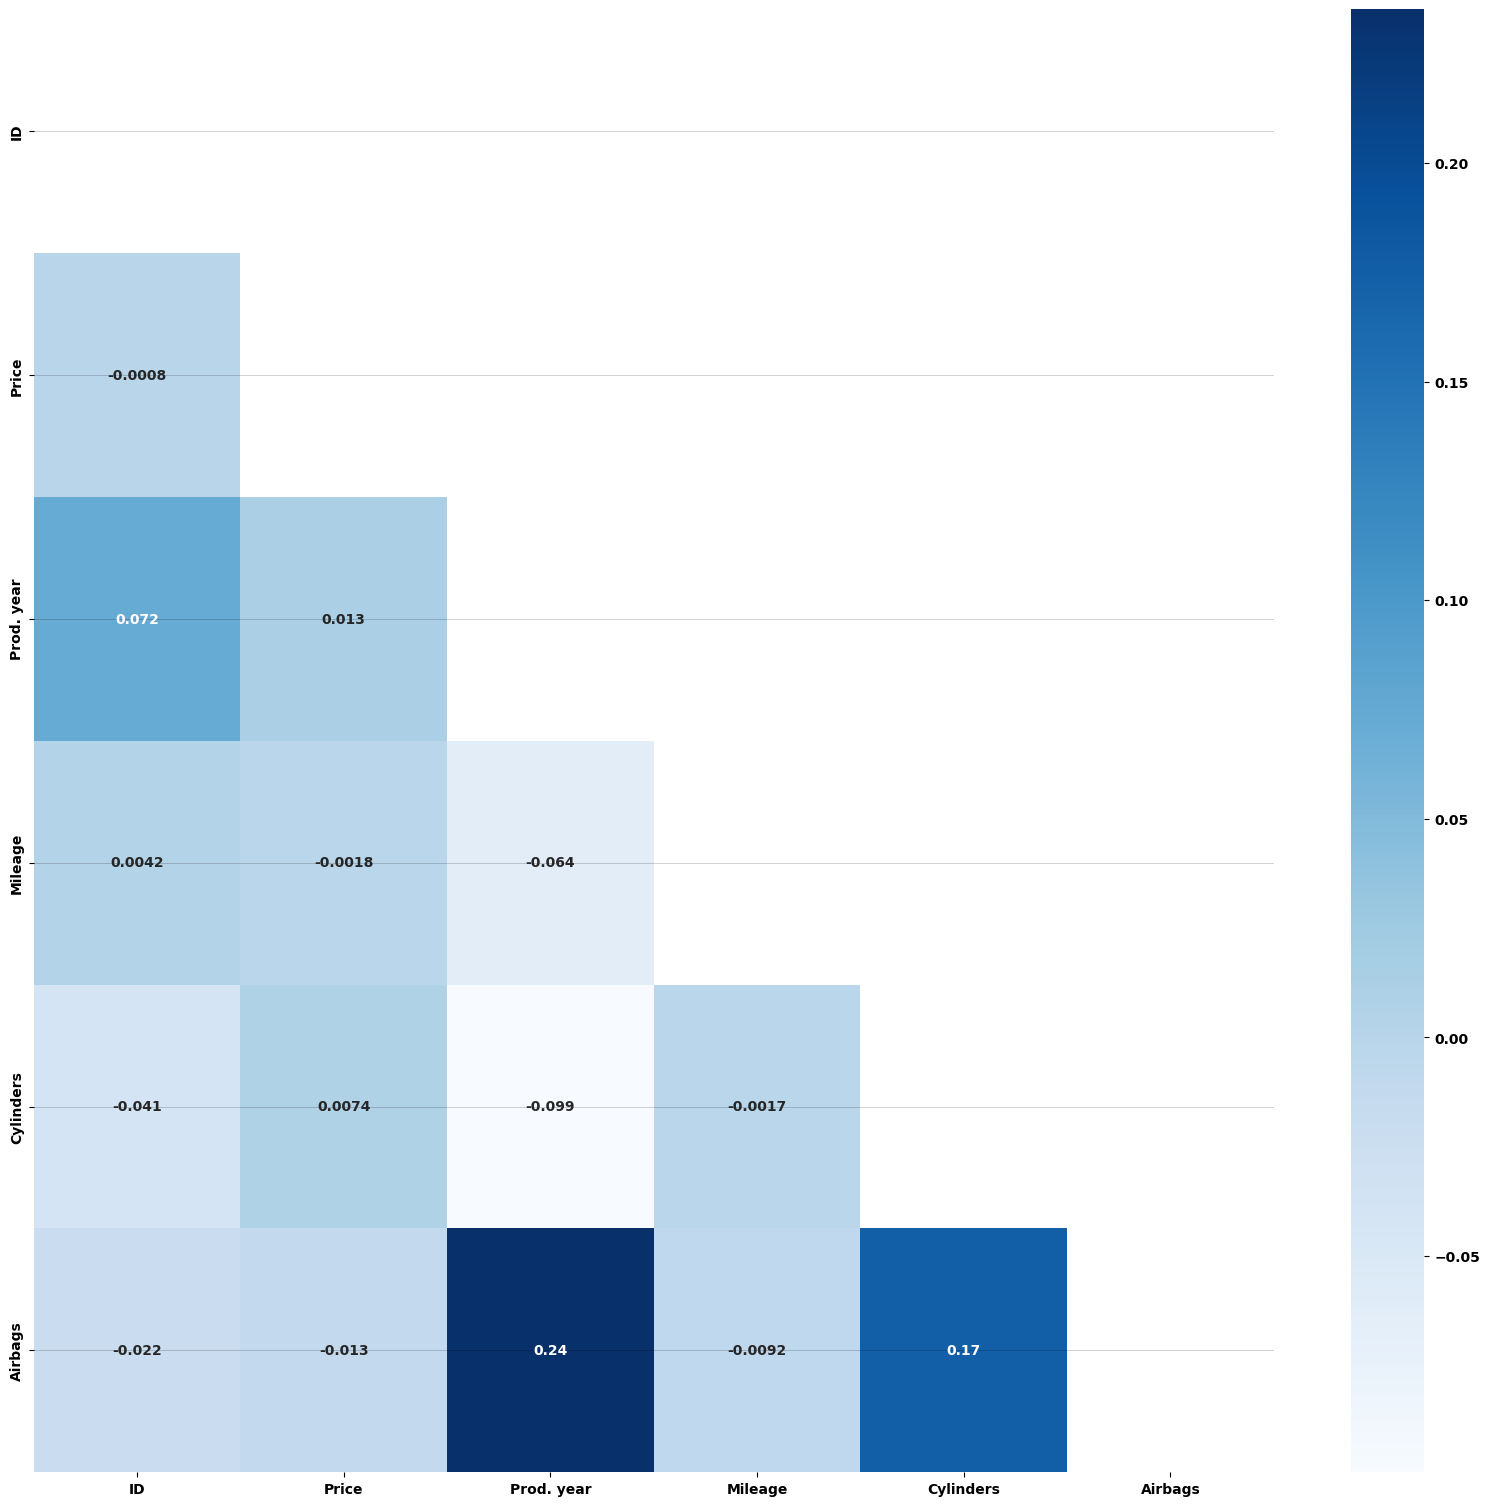

In [20]:
# code for heatmap

mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize = (20,19))
sns.heatmap(corr, cmap= 'Blues', annot = True, mask = mask);

In [21]:
df = df.drop(columns=['ID','Wheel','Doors','Levy'])

## Outliers

- No extreme outliers
  - There are mileage rows that are 0
  - There are cars with 16 airbags and some that are 0

In [22]:
df.describe(include="number")

,Price,Prod. year,Mileage,Cylinders,Airbags
count,1.892400e+04,18924.000000,1.892400e+04,18924.000000,18924.000000
mean,1.858744e+04,2010.914236,1.555373e+06,4.580216,6.568379
std,1.921356e+05,5.665749,4.880221e+07,1.200223,4.322323
min,1.000000e+00,1939.000000,0.000000e+00,1.000000,0.000000
25%,5.331000e+03,2009.000000,7.019575e+04,4.000000,4.000000
50%,1.317200e+04,2012.000000,1.264000e+05,4.000000,6.000000
75%,2.206300e+04,2015.000000,1.891198e+05,4.000000,12.000000
max,2.630750e+07,2020.000000,2.147484e+09,16.000000,16.000000


In [23]:
df.describe(include="object")

,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Gear box type,Drive wheels,Color
count,18924,18924,18924,18924,18924,18924,18924,18924,18924
unique,65,1590,11,2,7,107,4,3,16
top,HYUNDAI,Prius,Sedan,Yes,Petrol,2,Automatic,Front,Black
freq,3729,1069,8600,13731,9944,3856,13282,12695,4944


In [24]:
df['Mileage'].value_counts()

0         714
200000    181
150000    159
160000    120
180000    117
         ... 
100563      1
354300      1
21178       1
110539      1
186923      1
Name: Mileage, Length: 7687, dtype: int64

In [25]:
df['Mileage'] = df['Mileage'].astype(int)

## Univariate Visuals

### Price by fuel type analysis

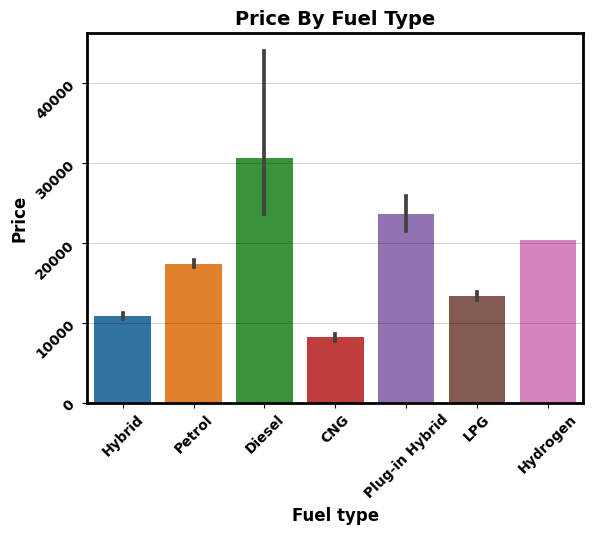

In [26]:
ax = sns.barplot(data=df,
                 x= 'Fuel type',
                 y = 'Price')

ax.tick_params(rotation = 45)

# Title
ax.set_title('Price By Fuel Type');

- Here we see that hybrid cars and diesel have the highest prices associated with them.
- Cars that use diesel have the highest prices assoicated with them.
- Contrary to diesel, the plug in hybrid are consistantly priced high as well


### Price by color analysis

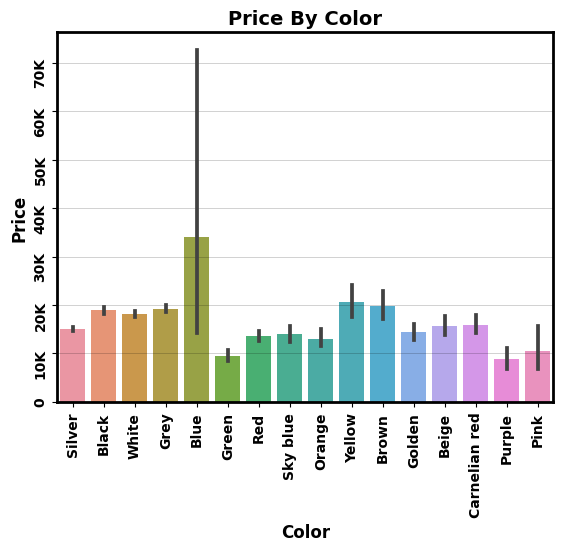

In [30]:
ax = sns.barplot(data=df,
                 x= 'Color',
                 y = 'Price')
def format_large_tick_values(tick_val, pos):
    if tick_val >= 1e3:
        val = int(tick_val) / 1e3
        return f'{val:.0f}K'
    else:
        return int(tick_val)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_large_tick_values))

ax.tick_params(rotation = 90)

# Title
ax.set_title('Price By Color');

- Blue cars have the more expensive cars.
- all the other cars have similar pricing amongst them.

# Modeling

## Numeric

In [ ]:
X = df.drop(columns=['Price'])
y = df['Price']

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18924 entries, 0 to 19236
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             18924 non-null  int64 
 1   Manufacturer      18924 non-null  object
 2   Model             18924 non-null  object
 3   Prod. year        18924 non-null  int64 
 4   Category          18924 non-null  object
 5   Leather interior  18924 non-null  object
 6   Fuel type         18924 non-null  object
 7   Engine volume     18924 non-null  object
 8   Mileage           18924 non-null  int64 
 9   Cylinders         18924 non-null  int64 
 10  Gear box type     18924 non-null  object
 11  Drive wheels      18924 non-null  object
 12  Color             18924 non-null  object
 13  Airbags           18924 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 2.2+ MB


In [ ]:
# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

# create preprocessing pipeline
preprocessor = make_column_transformer((ohe, cat_cols), (scaler, num_cols),remainder='drop', verbose_feature_names_out=False)

#pipeline

# Examine the results of all transformers
preprocessor.fit_transform(X_train,y_train).shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(14193, 1539)

In [ ]:
logreg_base = LogisticRegression(max_iter=10)

logreg_base = make_pipeline(preprocessor, logreg_base)

logreg_base.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78811c39a4d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78811c3bb040>)],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(max_iter=10))])

In [ ]:
# evaluate model
evaluate_classification(logreg_base, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         6
          25       0.00      0.00      0.00        11
          30       0.25      0.60      0.35        57
          31       0.00      0.00      0.00         9
          34       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         8
          36       0.00      0.00      0.00         1
          40       0.00      0.00      0.00        22
          45       0.00      0.00      0.00         6
        

In [ ]:
logreg_base.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x78811c39a4d0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x78811c3bb040>)],
                     verbose_feature_names_out=False)),
  ('logisticregression', LogisticRegression(max_iter=10))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector objec

In [ ]:
# Remaking the model with solver='liblinear'
log_reg_pipe = make_pipeline(make_column_transformer, LogisticRegression(solver='liblinear',
                                                       max_iter=500,
                                                       penalty='l1',
                                                       random_state=42))
# Define the param grid
params={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],}
# Create the GridSearchCV object with required args
gs = GridSearchCV(logreg_base, params, n_jobs=-1,
                  return_train_score=True,scoring='recall_macro').fit(X_train, y_train)
# Fit the gridsearch and display best params
gs.fit(X_train, y_train)
print(f'Best Params: {gs.best_params_}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
